In [36]:
import pandas as pd
import torch
import re
import nltk
import nltk.data
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import datetime

In [17]:
# Ensure necessary NLTK resources are available
def download_nltk_resources():
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')

    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')

    try:
        nltk.data.find('sentiment/vader_lexicon')
    except LookupError:
        nltk.download('vader_lexicon')

download_nltk_resources()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\count\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
# Load pre-trained BERT sentiment model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="model_cache")
model = AutoModelForSequenceClassification.from_pretrained(model_name, cache_dir="model_cache")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to evaluation mode
model.eval()




# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

In [29]:
# Function to apply sentiment prediction in batches
def bert_batch_predict(sentences):
    if not all(isinstance(s, str) for s in sentences):
        raise ValueError("All inputs must be strings")

    inputs = tokenizer(sentences, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    probabilities = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
    return probabilities.tolist(), ["Positive" if p > 0.6 else "Negative" if p < 0.4 else "Neutral" for p in probabilities]

In [31]:
# Function to compute VADER sentiment
def vader_sentiment(sentence):
    sentiment_score = sia.polarity_scores(sentence)['compound']
    if sentiment_score >= 0.05:
        return sentiment_score, "Positive"
    elif sentiment_score <= -0.05:
        return sentiment_score, "Negative"
    else:
        return sentiment_score, "Neutral"

In [48]:
print(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S"))

27.Feb 2025 22:17:55


In [50]:
filelist = ['./datasets/__sprint1_filtered_gameplay_review_set',
            './datasets/__sprint1_filtered_functionality_review_set',
            './datasets/__sprint1_filtered_usability_review_set']

set_names = ['gameplay', 'functionality','usability']

for index in range(len(filelist)):
    df = pd.read_csv(filelist[index] + '.csv', encoding='utf-8')
    df = df.dropna(subset=['tokenized_sentence'])
    df['tokenized_sentence'] = df['tokenized_sentence'].astype(str)
    df = df[df['tokenized_sentence'].str.strip() != ""]
    
    # Convert the column to a NumPy array for efficient slicing
    df_sentences_list = df['tokenized_sentence'].values  # Use .values instead of .tolist() for better performance
    
    # Batch processing
    batch_size = 32
    num_batches = int(np.ceil(len(df_sentences_list) / batch_size))  # Compute the number of batches
    
    # Initialize arrays for efficiency
    bert_scores = np.zeros(len(df_sentences_list))
    bert_labels = np.empty(len(df_sentences_list), dtype=object)
    vader_scores = np.zeros(len(df_sentences_list))
    vader_labels = np.empty(len(df_sentences_list), dtype=object)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(df_sentences_list))
        batch_sentences = df_sentences_list[start_idx:end_idx].tolist()  # Convert NumPy array to list
    
        # DistilBERT Sentiment Prediction
        scores, labels = bert_batch_predict(batch_sentences)  # Pass list to function
        bert_scores[start_idx:end_idx] = scores
        bert_labels[start_idx:end_idx] = labels
    
        # VADER Sentiment Prediction
        vader_results = np.array([vader_sentiment(sentence) for sentence in batch_sentences])
        vader_scores[start_idx:end_idx] = vader_results[:, 0]
        vader_labels[start_idx:end_idx] = vader_results[:, 1]
    
    # Assign predictions back to the DataFrame
    df["bert_score"] = bert_scores
    df["bert_label"] = bert_labels
    df["vader_score"] = vader_scores
    df["vader_label"] = vader_labels
    df.to_csv(filelist[index] + '_with_sentiment_scores.csv', index=False)

In [51]:
#Started execution at 21:50 

In [52]:
print(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S"))

27.Feb 2025 22:50:28


In [41]:
df.tail(20)

,Unnamed: 0,recommendationid,clean_sentence,tokenized_sentence,voted_up,informative,heuristic,bert_score,bert_label,vader_score,vader_label
118711,523525,52918061,every experience unique different,every experience is unique and different,1,1.0,"[('G',)]",0.999780,Positive,0.0000,Neutral
118712,523534,43980732,find gems spark inspiration rare,you will find gems here and there that will sp...,1,1.0,"[('G',)]",0.999736,Positive,0.3919,Positive
118713,523544,34593712,game like space minecraft stand game either,this game is like a space minecraft and i can ...,0,1.0,"[('G',)]",0.011154,Negative,0.3612,Positive
118714,523555,52284388,hopping planet planet explore tech make way core,you do this by hopping from planet to planet a...,0,1.0,"[('G',)]",0.999579,Positive,0.0000,Neutral
118715,523557,25383677,slow pace makes relaxing gameplay,its slow pace makes for a relaxing gameplay,1,1.0,"[('G',)]",0.998674,Positive,0.4939,Positive
118716,523558,28126654,standard priced game divide number hours revie...,its a standard priced game divide it by the nu...,1,1.0,"[('G',)]",0.036033,Negative,0.4939,Positive
118717,523560,60575720,game feels pretty good still handles well,in vr this game feels pretty good and still ha...,1,1.0,"[('G',)]",0.999841,Positive,0.8020,Positive
118718,523563,24867214,got bored quickly launch liking,i got bored quickly after launch but now im li...,1,1.0,"[('G', 'U')]",0.998245,Positive,0.4588,Positive
118719,523565,24973617,sure game repetitive love repetitive openworld...,sure this game is very repetitive but i love r...,1,1.0,"[('G',)]",0.991135,Positive,-0.4411,Negative
118720,523574,24913169,flying feels messy restrictive still feels lik...,flying feels messy and restrictive but it stil...,1,1.0,"[('G',)]",0.122557,Negative,0.3612,Positive


In [62]:
g_set = pd.read_csv('datasets/__sprint1_filtered_gameplay_review_set_with_sentiment_scores.csv', encoding='utf-8')
u_set = pd.read_csv('datasets/__sprint1_filtered_usability_review_set_with_sentiment_scores.csv', encoding='utf-8')
f_set = pd.read_csv('datasets/__sprint1_filtered_functionality_review_set_with_sentiment_scores.csv', encoding='utf-8')

In [64]:
g_set.tail()

,Unnamed: 0,recommendationid,clean_sentence,tokenized_sentence,voted_up,informative,heuristic,bert_score,bert_label,vader_score,vader_label
118726,523608,46006553,exploring,exploring,0,1.0,"[('G',)]",0.999738,Positive,0.0000,Neutral
118727,523610,24966390,guys making joe danger life first new game big...,these guys have been making joe danger most of...,1,1.0,"[('G',)]",0.997516,Positive,-0.5267,Negative
118728,523617,24863026,fanatastic exploration game,its a fanatastic exploration game,1,1.0,"[('G',)]",0.999661,Positive,0.2263,Positive
118729,523629,66834086,games awesome youre exploration discovery amaz...,this games awesome if youre into exploration d...,1,1.0,"[('G',)]",0.998691,Positive,0.8910,Positive
118730,523643,25174939,homogenous resource availability,homogenous resource availability 5,0,1.0,"[('G',)]",0.926759,Positive,0.0000,Neutral


In [387]:
g_avg_bert = g_set['bert_score'].mean()
g_avg_vader = g_set['vader_score'].mean()
f_avg_bert = f_set['bert_score'].mean()
f_avg_vader = f_set['vader_score'].mean()
u_avg_bert = u_set['bert_score'].mean()
u_avg_vader = u_set['vader_score'].mean()

In [218]:
print(g_set['bert_score'].max())

0.9998948574066162


In [389]:
print(g_avg_bert)
print(f_avg_bert)
print(u_avg_bert)
g_avg_bert = g_avg_bert * 2 -1
f_avg_bert = f_avg_bert * 2 -1
u_avg_bert = u_avg_bert * 2 -1
print(g_avg_bert)
print(f_avg_bert)
print(u_avg_bert)


0.46668513802892964
0.28753227327489317
0.3575584030640064
-0.06662972394214073
-0.42493545345021366
-0.28488319387198724


In [391]:
print(g_avg_vader)
print(f_avg_vader)
print(u_avg_vader)

0.16328032443085627
0.0478551458950982
0.06781070405617666


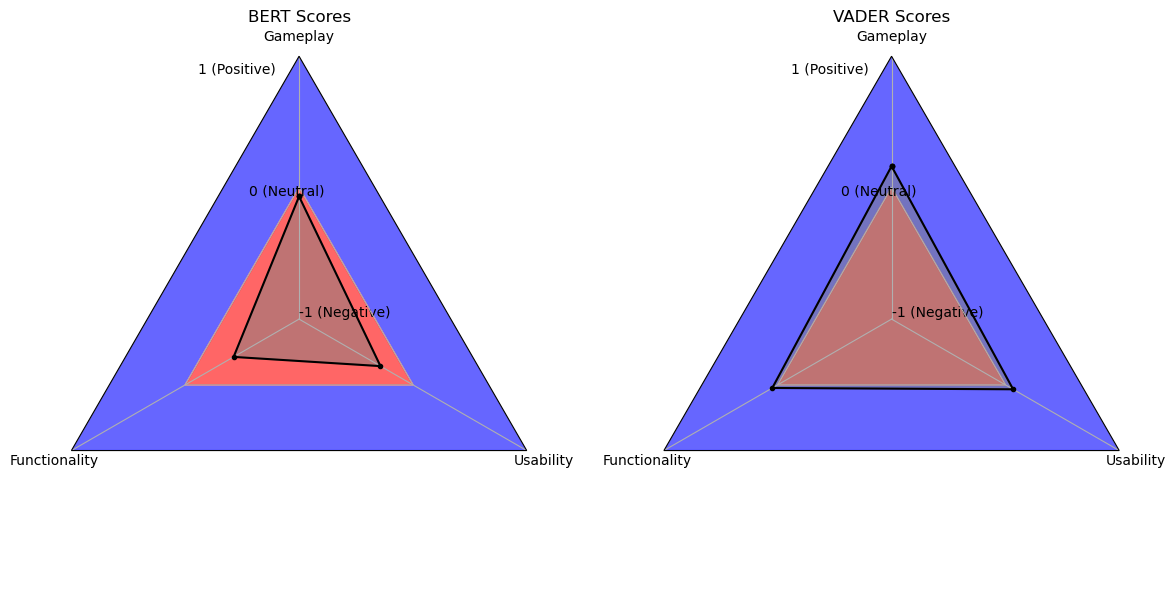

In [378]:
import numpy as np
import matplotlib.pyplot as plt

# Define categories (3 metrics for triangular radar chart)
categories = ['Gameplay', 'Functionality', 'Usability']


# Sample values ranging from -1 to 1
values0 = [0,0,0]  # Dataset 1
values0 += [values0[0]]
values9 = [1,1,1]  # Dataset 1
values9 += [values9[0]]

values1 = [g_avg_bert, f_avg_bert, u_avg_bert]  # Dataset 1
values2 = [g_avg_vader, f_avg_vader, u_avg_vader]  # Dataset 2

# Ensure the data closes the radar chart
values1 += [values1[0]]
values2 += [values2[0]]

# Generate angles for the radar chart (3 axes for triangle shape)
angles = np.linspace(0, 2 * np.pi, len(categories) + 1, endpoint=True)

# Create subplots for two radar charts
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='radar'), figsize=(12,7))

# Function to adjust radial limits for values between -1 and 1
def adjust_polar_axis(ax):
    ax.set_ylim(-1, 1)  # Set limits to allow negative values
    ax.set_yticks([-1, 0, 1])  # Define y-axis ticks
    ax.set_yticklabels(['-1 (Negative)',  '0 (Neutral)', '1 (Positive)'])  # Labels for y-axis
    ax.set_xticks(angles[:-1])  # Set category labels at correct angles
    ax.set_xticklabels(categories)

# Plot first triangular radar chart
axs[0].fill(angles, values9, color='b', alpha=0.6)
axs[0].fill(angles, values0, color='white', alpha=1)
axs[0].fill(angles, values0, color='r', alpha=0.6)

axs[0].plot(angles, values1, marker='.', linestyle='solid', color='black', label="BERT Scores")
axs[0].fill(angles, values1, color='grey', alpha=.5)
adjust_polar_axis(axs[0])
axs[0].set_title("BERT Scores")

# Plot second triangular radar chart
axs[1].fill(angles, values9, color='b', alpha=0.6)
axs[1].fill(angles, values0, color='white', alpha=1)
axs[1].fill(angles, values0, color='r', alpha=0.6)

axs[1].plot(angles, values2, marker='.', linestyle='solid', color='black', label="VADER Scores")
axs[1].fill(angles, values2, color='grey', alpha=.5)
adjust_polar_axis(axs[1])
axs[1].set_title("VADER Scores")

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('bert_vader_comparison_plots.png')
plt.show()

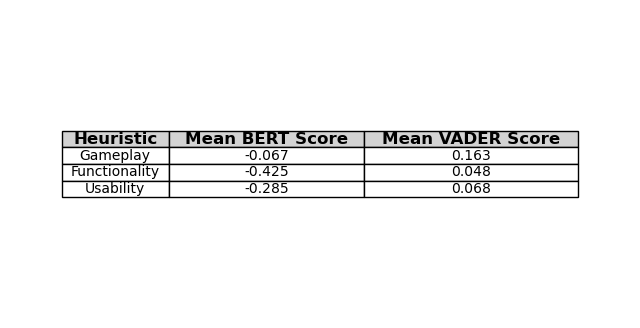

In [401]:

# Define table data
data = [
    #["Heuristic", "Mean BERT Score", "Mean VADER Score"],
    ["Gameplay", f"{g_avg_bert:.3f}", f"{g_avg_vader:.3f}"],
    ["Functionality", f"{f_avg_bert:.3f}", f"{f_avg_vader:.3f}"],
    ["Usability",f"{u_avg_bert:.3f}", f"{u_avg_vader:.3f}"]
]

# Define column labels
columns = ["Heuristic", "Mean BERT Score", "Mean VADER Score"]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create table
table = ax.table(cellText=data, colLabels=columns, cellLoc='center', loc='center')

# Styling the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2])  # Adjust column widths

# Style the header row (make it bold and set background color to grey)
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('lightgrey')

# Display table
plt.show()
